<b><p style="text-align:center;font-size: 32px;"> Projet n°7</p><b>
<b><p style="text-align:center;font-size: 32px;"> Réalisez une analyse de sentiments grâce au Deep Learning</p><b>
<b><p style="text-align:center;font-size: 32px;"> Implémentation des modèles</p><b>

# Introduction

Dans ce notebook, nous implémentons et comparons plusieurs modèles de prédiction de sentiments appliqués à des tweets. Trois approches sont explorées : un modèle sur mesure simple utilisant une régression logistique, deux modèles avancés reposant sur des réseaux de neurones profonds , ainsi qu’un modèle avancé de type transformer basé sur BERT. Chaque expérimentation (entraînement et test d'un modèle) est suivie et tracée avec MLflow, permettant l’enregistrement automatique des paramètres, métriques de performance et artefacts produits à chaque étape.

# Imports des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
import seaborn as sns
import tensorflow as tf
import string
import nltk
import mlflow
import mlflow.sklearn
import re
import time
import os

from mlflow.models.signature import infer_signature

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import BaseEstimator

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

from transformers import DistilBertTokenizerFast, create_optimizer
from transformers import TFDistilBertForSequenceClassification, TFPreTrainedModel

2025-05-05 20:59:27.722632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 20:59:27.722683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 20:59:27.723715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 20:59:27.729706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-05 20:59:28.651440: W tensorflow/compiler/tf2

# Fonctions pour le suivi des expérimentations

In [2]:
def log_experiment(model, params, metrics, artifacts, input_example, times, model_name=None):
    """
    Enregistre une expérimentation de modèle dans MLflow.

    Cette fonction trace un run MLflow incluant :
    - les hyperparamètres du modèle,
    - les métriques d’évaluation,
    - les temps de traitement,
    - un exemple d’entrée pour signature,
    - le modèle lui-même (Keras ou Scikit-learn),
    - et les artefacts éventuels (fichiers supplémentaires).

    Parameters
    ----------
    model : object
        Modèle entraîné à enregistrer. Doit être un modèle Keras (`tf.keras.Model`) 
        ou un estimateur Scikit-learn (`BaseEstimator`).

    params : dict
        Dictionnaire des hyperparamètres et métadonnées liés à l’entraînement.

    metrics : dict
        Dictionnaire des métriques de performance à enregistrer.

    artifacts : dict
        Dictionnaire des artefacts à enregistrer (fichiers, chemins).

    input_example : array-like
        Exemple d’entrée pour générer la signature du modèle (utile pour le suivi et le déploiement).

    times : dict
        Dictionnaire des durées ou temps mesurés (par ex. temps d'entraînement, d'inférence).

    model_name : str, optional
        Nom du modèle à logguer comme paramètre dans MLflow.
    """
    with mlflow.start_run() as run:
        # Log du nom du modèle
        if model_name:
            params["model_name"] = model_name

        params["data_sample_size"] = sample_size

        # Log des paramètres
        mlflow.log_params(params)

        # Log des métriques
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        # Log des temps
        for time_name, time_value in times.items():
            mlflow.log_metric(time_name, time_value)

        # -------- Signature ----------
        if hasattr(model, "predict"):
            raw_preds = model.predict(input_example)
        else:
            raw_preds = model(input_example)            
        # Si logits, extraire et convertir
        if hasattr(raw_preds, "logits"):
            raw_preds = raw_preds.logits            
        # Convertir en numpy si possible
        if isinstance(raw_preds, tf.Tensor):
            raw_preds = raw_preds.numpy()
        elif not isinstance(raw_preds, np.ndarray):
            raw_preds = np.array(raw_preds)
            
        signature = infer_signature(input_example, raw_preds)

        # Log du modèle selon le type
        if isinstance(model, tf.keras.Model):
            mlflow.tensorflow.log_model(model, "model", signature=signature, 
                                        pip_requirements=["tensorflow==2.15.0"])
        elif isinstance(model, BaseEstimator):
            mlflow.sklearn.log_model(model, "model", signature=signature)
        else:
            raise ValueError("Type de modèle non supporté pour l'enregistrement MLflow.")

        # Artefacts éventuels
        for artifact_name, artifact_value in artifacts.items():
            mlflow.log_artifact(artifact_value)

        print(f"Modèle et résultats enregistrés dans MLflow sous le run ID: {run.info.run_id}")

In [3]:
def log_model_layers(model):
    """ Extrait et logge les détails des couches d'un modèle Keras dans MLflow """
    params = {}

    for i, layer in enumerate(model.layers):
        layer_type = type(layer).__name__
        params[f'layer_{i}_type'] = layer_type

        # Cas spécial pour Embedding
        if isinstance(layer, tf.keras.layers.Embedding):
            params[f'layer_{i}_input_dim'] = layer.input_dim
            params[f'layer_{i}_output_dim'] = layer.output_dim
            params[f'layer_{i}_trainable'] = layer.trainable

        # Cas spécial pour Bidirectional
        elif isinstance(layer, tf.keras.layers.Bidirectional):
            fwd = layer.forward_layer
            bwd = layer.backward_layer
            params[f'layer_{i}_forward_type'] = type(fwd).__name__
            params[f'layer_{i}_backward_type'] = type(bwd).__name__
            params[f'layer_{i}_units'] = fwd.units
            params[f'layer_{i}_dropout'] = fwd.dropout
            params[f'layer_{i}_recurrent_dropout'] = fwd.recurrent_dropout

        # Pour les couches Dense, LSTM, etc.
        else:
            if hasattr(layer, 'units'):
                params[f'layer_{i}_units'] = layer.units
            if hasattr(layer, 'activation'):
                params[f'layer_{i}_activation'] = layer.activation.__name__
            if hasattr(layer, 'dropout'):
                params[f'layer_{i}_dropout'] = layer.dropout
            if hasattr(layer, 'recurrent_dropout'):
                params[f'layer_{i}_recurrent_dropout'] = layer.recurrent_dropout

        # Ajouter trainable (utile pour toutes les couches)
        params[f'layer_{i}_trainable'] = layer.trainable

    return params

In [4]:
def plot_history(history):
    """
    Affiche les courbes d'apprentissage d'un modèle entraîné avec Keras.

    Cette fonction trace l'évolution de la loss, de l'accuracy et de l'AUC 
    sur les ensembles d'entraînement et de validation au fil des epoques, 
    à partir de l'objet `History` retourné par la méthode `fit()` d’un modèle Keras.

    Paramètres
    ----------
    history : keras.callbacks.History
        Objet retourné par la méthode `model.fit()`, contenant les historiques
        d'entraînement et de validation pour différentes métriques.
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend()

     # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend()

    # AUC
    axes[2].plot(history.history['auc'], label='Train AUC')
    axes[2].plot(history.history['val_auc'], label='Val AUC')
    axes[2].set_xlabel('Epoch', fontsize=14)
    axes[2].set_ylabel('AUC', fontsize=14)
    axes[2].legend()

# Préparation des données

## Fonctions pour le nettoyage des données

In [5]:
def clean_tweet(tweet):
    # 1. Convertir en minuscules
    tweet = tweet.lower()

    # 2. Supprimer les mentions (@user)
    tweet = re.sub(r"@\w+", "", tweet)

    # 3. Remplacer les URLs par "URL"
    tweet = re.sub(r"http\S+|www\S+|https\S+", "URL", tweet, flags=re.MULTILINE)

    # 4. Gérer les hashtags (#word → word)
    tweet = re.sub(r"#(\w+)", r"\1", tweet)

    # 5. Réduire les répétitions de lettres (ex: coooool → cool)
    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)

    # 6. Supprimer la ponctuation excessive et les caractères spéciaux
    tweet = re.sub(r"[^a-zA-Z0-9\s]", "", tweet)

    return tweet

In [6]:
def lemmatize_text(text, lemmatizer):    
    tokens = word_tokenize(text)  # Tokenizer le texte en mots
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens) # reassemble les tokens en phrases

## Import et analyse des données

On commence par importer le jeu de données Sentiment140.

In [7]:
col_names = ['target', 'ids', 'date', 'flag', 'user','text']
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',
                     encoding='latin-1',
                     header=None,
                     names=col_names
                    )

In [8]:
tweets

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Le jeu de données contient 1.6 millions de tweets. La target indique le sentiment associé au tweet : la valeur 0 correspond à un sentiment négatif et la valeur 4 à un sentiment positif. Les classes de sentiments sont bien équilibrées :

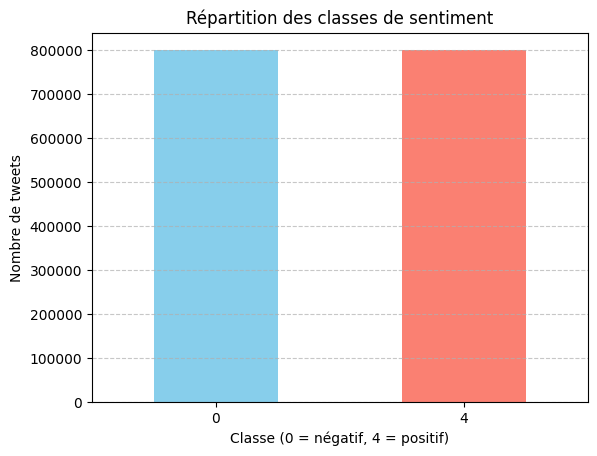

In [9]:
# affichage de la répartition des classes du dataset
tweets['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Répartition des classes de sentiment')
plt.xlabel('Classe (0 = négatif, 4 = positif)')
plt.ylabel('Nombre de tweets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Il n'y a pas de valeur manquante parmi les données :

In [10]:
tweets.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

On remplace les valeurs "4" de la target par "1", et on conserve uniquement les colonnes "target" et "text"

In [11]:
# changer les valeurs de la target : 4 ==> 1
tweets['target'] = tweets['target'].map({0: 0, 4: 1})

In [12]:
tweets = tweets[['target', 'text']]

## Nettoyage des tweets

In [13]:
# Nettoyer les tweets
tweets.loc[:, "text"] = tweets["text"].apply(clean_tweet)

In [14]:
# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()
# Appliquer la lemmatisation (à décommenter pour tester influence lemmatisation)
# tweets['text'] = tweets['text'].apply(lambda x: lemmatize_text(x, lemmatizer))

## Sélection d'un échantillon

En raison de la taille du jeu de données global, on en sélectionne seulement un échantillon :

In [15]:
sample_size = 0.1 # échantillon de 10%, cette taille peut être modifiée
tweets_sample, _ = train_test_split(
    tweets,
    test_size=(1-sample_size),
    stratify=tweets['target'], # pour respecter équilibre des classes
    random_state=42
)
tweets_sample.reset_index(drop=True, inplace=True)
tweets_sample

,target,text
0,1,forever the sickest kids are soo ace thank you...
1,1,bike race preparations begin
2,0,bored out of my mind wheres
3,0,this is not good sore throat head ache stuffy...
4,1,show just wrapped its called quoturban erotica...
...,...,...
159995,0,we have lots of raspberries in our yard but t...
159996,0,just got cupcake whats up with the ui the mus...
159997,0,is drown in naked in revenge
159998,1,fixing to practice


## Séparation en données d'entraînement et de test

On sépare avec 80 % des données de l'échantillon pour l'entraîment et 20 % pour le test :

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets_sample['text'],
    tweets_sample['target'],
    test_size=0.2,
    random_state=42,
    stratify=tweets_sample['target'] # pour respecter équilibre des classes
)

# Modèle sur mesure simple

Pour le modèle sur mesure simple, on entraîne une regression logisitique. La transformation des tweets en données numérique est effectuée avec une vectorisation TF-IDF.

## Vectorisation

In [17]:
# Vectorisation TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Entraînement avec validation croisée

In [18]:
# Initialisation du modèle
model_log_reg = LogisticRegression(max_iter=1000, random_state=42)

On entraîne le modèle avec une validation croisée et une optimisation du coefficient de régularisation par recherche sur grille.

In [19]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0]
}

In [20]:
# Choix des métriques
scorers = {
    'AUC':'roc_auc',
    'Accuracy': 'accuracy',
}

In [21]:
# Entrainement du modèle par validation croisée + gridsearch
grid_search_log_reg = GridSearchCV(   
    model_log_reg, 
    param_grid=param_grid, 
    scoring=scorers,          
    cv=5,                     # 5-fold cross-validation
    refit='Accuracy',         # Refit le meilleur modèle après optimisation
    return_train_score=True,
    n_jobs=1,
    verbose=3
)

In [22]:
# Entraînement du modèle
grid_search_log_reg.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.001; AUC: (train=0.789, test=0.786) Accuracy: (train=0.718, test=0.717) total time=   0.3s
[CV 2/5] END C=0.001; AUC: (train=0.790, test=0.785) Accuracy: (train=0.719, test=0.714) total time=   0.2s
[CV 3/5] END C=0.001; AUC: (train=0.790, test=0.785) Accuracy: (train=0.719, test=0.714) total time=   0.2s
[CV 4/5] END C=0.001; AUC: (train=0.790, test=0.786) Accuracy: (train=0.720, test=0.715) total time=   0.2s
[CV 5/5] END C=0.001; AUC: (train=0.790, test=0.786) Accuracy: (train=0.718, test=0.717) total time=   0.2s
[CV 1/5] END C=0.01; AUC: (train=0.817, test=0.813) Accuracy: (train=0.742, test=0.739) total time=   0.3s
[CV 2/5] END C=0.01; AUC: (train=0.818, test=0.811) Accuracy: (train=0.743, test=0.737) total time=   0.3s
[CV 3/5] END C=0.01; AUC: (train=0.818, test=0.811) Accuracy: (train=0.744, test=0.737) total time=   0.2s
[CV 4/5] END C=0.01; AUC: (train=0.818, test=0.813) Accuracy: (train=0.744, tes

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=1, param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0]},
             refit='Accuracy', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=3)

## Résultats de validation croisée

In [23]:
# Récupérer l'accuracy et les paramètres du meilleur modèle
print('Meilleur score :', grid_search_log_reg.best_score_.round(3))
print('Meilleurs paramètres :', grid_search_log_reg.best_params_)

Meilleur score : 0.784
Meilleurs paramètres : {'C': 1.0}


Résultats de la recherche par grille :

In [24]:
results_df = pd.DataFrame(grid_search_log_reg.cv_results_)

# Trier les résultats par accuracy décroissante 
results_df = results_df.sort_values(by='rank_test_Accuracy')

# Sélection des colonnes 
columns_of_interest = ['rank_test_Accuracy', 'params', 'mean_test_Accuracy',
                           'mean_test_AUC', 'mean_fit_time', 'mean_score_time'
                          ]

display(results_df[columns_of_interest])

,rank_test_Accuracy,params,mean_test_Accuracy,mean_test_AUC,mean_fit_time,mean_score_time
3,1,{'C': 1.0},0.784047,0.864889,2.734610,0.024723
4,2,{'C': 10.0},0.774570,0.856354,8.460350,0.019728
2,3,{'C': 0.1},0.770102,0.848895,1.389800,0.014289
1,4,{'C': 0.01},0.737547,0.812238,0.280864,0.014218
0,5,{'C': 0.001},0.715094,0.785836,0.224189,0.013649


## Prédiction sur les données de test

On utilise le meilleur modèle pour effectuer les prédictions sur les données de test :

In [25]:
# prédictions sur le jeu de test
start_pred_time = time.time() 
y_pred_test = grid_search_log_reg.best_estimator_.predict(X_test_tfidf)
test_pred_time = time.time() - start_pred_time

y_proba_test = grid_search_log_reg.best_estimator_.predict_proba(X_test_tfidf)[:, 1]

## Calcul des métriques

On calcule les différentes métriques :

In [26]:
# Récupère les scores obtenus sur le jeu d'entraînement
train_accuracy = results_df['mean_train_Accuracy'].iloc[0]
train_AUC = results_df['mean_train_AUC'].iloc[0]

# Calcul des métriques sur le jeu de test
test_accuracy = accuracy_score(y_test, y_pred_test)
test_AUC = roc_auc_score(y_test, y_proba_test)

print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Train AUC: {train_AUC:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test AUC: {test_AUC:.3f}')

Train Accuracy: 0.830
Train AUC: 0.905
Test Accuracy: 0.789
Test AUC: 0.868


## Enregistrements avec MLflow

On rassemble les éléments à enregistrer dans des dictionnaires :

In [27]:
# Dictionnaire des métriques
metrics = {
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

In [28]:
# Tracé de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Régression Logistique - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_log_reg.png')
plt.close()

In [29]:
# Dictionnaire des artefacts
artifacts = {
    'roc_curve': 'roc_curve_log_reg.png',
}

In [30]:
fit_time = results_df['mean_fit_time'].iloc[0]

In [31]:
# Dictionnaire des temps de calcul
times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

In [32]:
# Exemple de donnée d'entrée du modèle
input_example = vectorizer.transform(['Exemple de texte pour signature modèle.'])

In [33]:
# Défini le dossier où sont enregistrées les expérimentations
mlflow.set_tracking_uri("../mlruns/")

In [34]:
# Appel de la fonction de log MLflow
log_experiment(
    grid_search_log_reg.best_estimator_,
    grid_search_log_reg.best_params_,
    metrics,
    artifacts,
    input_example,
    times,
    "Logistic_regression"
)

Modèle et résultats enregistrés dans MLflow sous le run ID: 39e7c3ecced940ccb39e4fc2001a684c


# Modèles sur mesure avancés

On teste deux types de modèles utilisant des réseaux de neurones profonds : un modèle LSTM Bi-directionnel (réseau de neurones récurrent) et un réseau de convolution (CNN).

## Fonctions de construction des modèles

In [35]:
def build_LSTM_model(embedding_matrix):
    """
    Construit un modèle de classification binaire basé sur un réseau BiLSTM avec
    embeddings pré-entraînés.

    Parameters
    ----------
    embedding_matrix : np.ndarray
        Matrice d'embedding pré-entraînée (par ex. GloVe), de forme (vocab_size, embedding_dim).
        Elle est utilisée pour initialiser la couche d’embedding et reste figée pendant l’entraînement.

    Returns
    -------
    model : tf.keras.Model
        Modèle Keras compilé, prêt à être entraîné.
    """
    max_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(128, dropout=0.4)),
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['accuracy', AUC(name="auc")])

    return model

In [36]:
def build_CNN_model(embedding_matrix):
    """
    Construit un modèle de classification binaire basé sur un réseau CNN avec
    embeddings pré-entraînés.

    Parameters
    ----------
    embedding_matrix : np.ndarray
        Matrice d'embedding pré-entraînée (par ex. GloVe), de forme (vocab_size, embedding_dim).
        Elle est utilisée pour initialiser la couche d’embedding et reste figée pendant l’entraînement.

    Returns
    -------
    model : tf.keras.Model
        Modèle Keras compilé, prêt à être entraîné.
    """
    max_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='binary_crossentropy',
                   metrics=['accuracy', AUC(name="auc")])

    return model

## Fonction de prétraitement

In [37]:
def tokenize_and_pad(corpus, X_train, X_test, max_words=10000, max_len=100):
    """
    Transforme les textes d'entraînement et de test en séquences d'entiers paddées,
    en utilisant un tokenizer entraîné sur l'ensemble complet des textes.

    Parameters
    ----------
    corpus: Liste ou série de tous les textes disponibles pour entraîner le tokenizer.
    X_train: Liste ou série de textes d'entraînement.
    X_test: Liste ou série de textes de test.
    max_words: Nombre maximum de mots à garder dans le vocabulaire.
    max_len: Longueur maximale des séquences (avec padding).

    Returns
    ----------
    Tuple (X_train_padded, X_test_padded, tokenizer)
        - X_train_padded : tableau numpy de séquences d'entiers pour l'entraînement
        - X_test_padded : tableau numpy de séquences d'entiers pour le test
        - tokenizer : objet Tokenizer entraîné sur tous les textes
    """
    # Entraîner le tokenizer sur tous les textes disponibles
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(corpus)

    # Transformer les textes d'entraînement et de test en séquences d'entiers
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_test = tokenizer.texts_to_sequences(X_test)

    # Appliquer le padding
    X_train_padded = pad_sequences(sequences_train, maxlen=max_len)
    X_test_padded = pad_sequences(sequences_test, maxlen=max_len)

    return X_train_padded, X_test_padded, tokenizer

In [38]:
max_words = 10000
max_len = 100
X_train_padded, X_test_padded, tokenizer = tokenize_and_pad(
    tweets['text'],
    X_train,
    X_test,
    max_words,
    max_len
)

## Matrices d'embeddings

Dans le cas du modèle LSTM, deux types de word embeddings ont été comparés : un embedding word2vec que l'on a entrainé sur l'ensemble des tweets de Sentiment140 et un embedding GloVe pré-entraîné sur un total de 2 milliards de tweets.

In [39]:
def w2v_embedding_matrix(tokenizer, word2vec_model, max_words, embedding_dim):
    """
    Crée une matrice d'embedding à partir d'un modèle Word2Vec entraîné.

    :param tokenizer: Tokenizer ajusté sur le texte.
    :param word2vec_model: Modèle Word2Vec entraîné.
    :param max_words: Nombre de mots dans le vocabulaire.
    :param embedding_dim: Dimension des embeddings.
    :return: Matrice d'embedding.
    """
    # Créer une matrice d'embedding
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            if word in word2vec_model.wv:
                embedding_matrix[i] = word2vec_model.wv[word]

    return embedding_matrix

In [40]:
def glove_embedding_matrix(tokenizer, max_words, embedding_dim=100):
    """
    Crée une matrice d'embedding à partir des embeddings GloVe chargés via Gensim.

    :param tokenizer: Tokenizer ajusté sur le texte.
    :param max_words: Nombre de mots dans le vocabulaire.
    :param embedding_dim: Dimension des embeddings GloVe.
    :return: Matrice d'embedding.
    """
    # Charger les embeddings GloVe via Gensim
    glove_model = api.load('glove-twitter-100')

    # Créer une matrice d'embedding
    embedding_matrix = np.zeros((max_words, embedding_dim))

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            if word in glove_model:
                embedding_matrix[i] = glove_model[word]

    return embedding_matrix

## LSTM avec embeddings Word2Vec

Entraînement de l'embedding word2vec sur l'ensemble des tweets de Sentiment140 (pas que sur l'échantillon) :

In [41]:
w2v_path = "twitter_word2vec.model"

# vérifier si le model a déjà été entrainé et enregistré
if os.path.exists(w2v_path):
    print("Chargement du modèle Word2Vec existant...")
    word2vec_model = Word2Vec.load(w2v_path)
else:
    print("Entraînement d'un nouveau modèle Word2Vec...")
    tokenized_text = tweets['text'].apply(word_tokenize)
    word2vec_model = Word2Vec(
        sentences=tokenized_text,
        vector_size=100,
        window=4,
        min_count=2
    )    
    word2vec_model.save(w2v_path)
    print("Modèle entraîné et sauvegardé.")

Chargement du modèle Word2Vec existant...


In [42]:
# construction de la matrice d'embeddings
embedding_matrix = w2v_embedding_matrix(tokenizer, word2vec_model, max_words,
                                        embedding_dim=100)

In [43]:
# construction du modèle LSTM
model_LSTM_w2v = build_LSTM_model(embedding_matrix)
model_LSTM_w2v.summary()

2025-05-05 21:01:26.583021: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 21:01:26.639475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 21:01:26.639537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 21:01:26.643788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 21:01:26.643866: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1234753 (4.71 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [44]:
def create_callbacks(model_name, patience):
    """
    Crée une liste de callbacks Keras pour le suivi et l'optimisation de l'entraînement.

    Cette fonction configure deux callbacks :
    - `ModelCheckpoint` : enregistre automatiquement le meilleur modèle
                          (basé sur la validation loss).
    - `EarlyStopping` : arrête l'entraînement si la validation loss ne s'améliore
                        plus après un certain nombre d'époques.

    Parameters
    ----------
    model_name : str
        Nom du modèle
    
    patience : int
        Nombre d’époques sans amélioration de la validation loss avant arrêt anticipé.

    Returns
    -------
    callbacks : list
        Liste contenant les callbacks `ModelCheckpoint` et `EarlyStopping`.
    """
    # Définir le callback ModelCheckpoint
    checkpoint_path = './checkpoints/' + model_name + '.keras'
    checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Sauvegarder le modèle entier
    monitor='val_loss',  # Surveiller la loss sur le jeu de validation
    mode='min',  # Sauvegarder le modèle lorsque la loss diminue
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
    verbose=1
    )

    # Définir le callback EarlyStopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=patience, restore_best_weights=True)
    
    return [checkpoint_callback, es]

In [45]:
callbacks_LSTM_w2v = create_callbacks(model_name="model_LSTM_w2v", patience=5)

In [46]:
# Entrainement du modèle LSTM
start_fit_time = time.time() 
history_LSTM_w2v = model_LSTM_w2v.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_LSTM_w2v,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/20


2025-05-05 21:01:29.603305: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-05 21:01:30.575275: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd1495c5ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-05 21:01:30.575319: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-05 21:01:30.580350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746471690.667711    7298 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3200/3200 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7316 - auc: 0.8087
Epoch 1: val_loss improved from inf to 0.46550, saving model to ./checkpoints/model_LSTM_w2v.keras
3200/3200 [==============================] - 80s 24ms/step - loss: 0.5323 - accuracy: 0.7316 - auc: 0.8087 - val_loss: 0.4655 - val_accuracy: 0.7766 - val_auc: 0.8645
Epoch 2/20
3198/3200 [============================>.] - ETA: 0s - loss: 0.4800 - accuracy: 0.7691 - auc: 0.8501
Epoch 2: val_loss improved from 0.46550 to 0.44017, saving model to ./checkpoints/model_LSTM_w2v.keras
3200/3200 [==============================] - 79s 25ms/step - loss: 0.4800 - accuracy: 0.7691 - auc: 0.8502 - val_loss: 0.4402 - val_accuracy: 0.7908 - val_auc: 0.8762
Epoch 3/20
3199/3200 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.7767 - auc: 0.8592
Epoch 3: val_loss improved from 0.44017 to 0.43256, saving model to ./checkpoints/model_LSTM_w2v.keras
3200/3200 [=========================

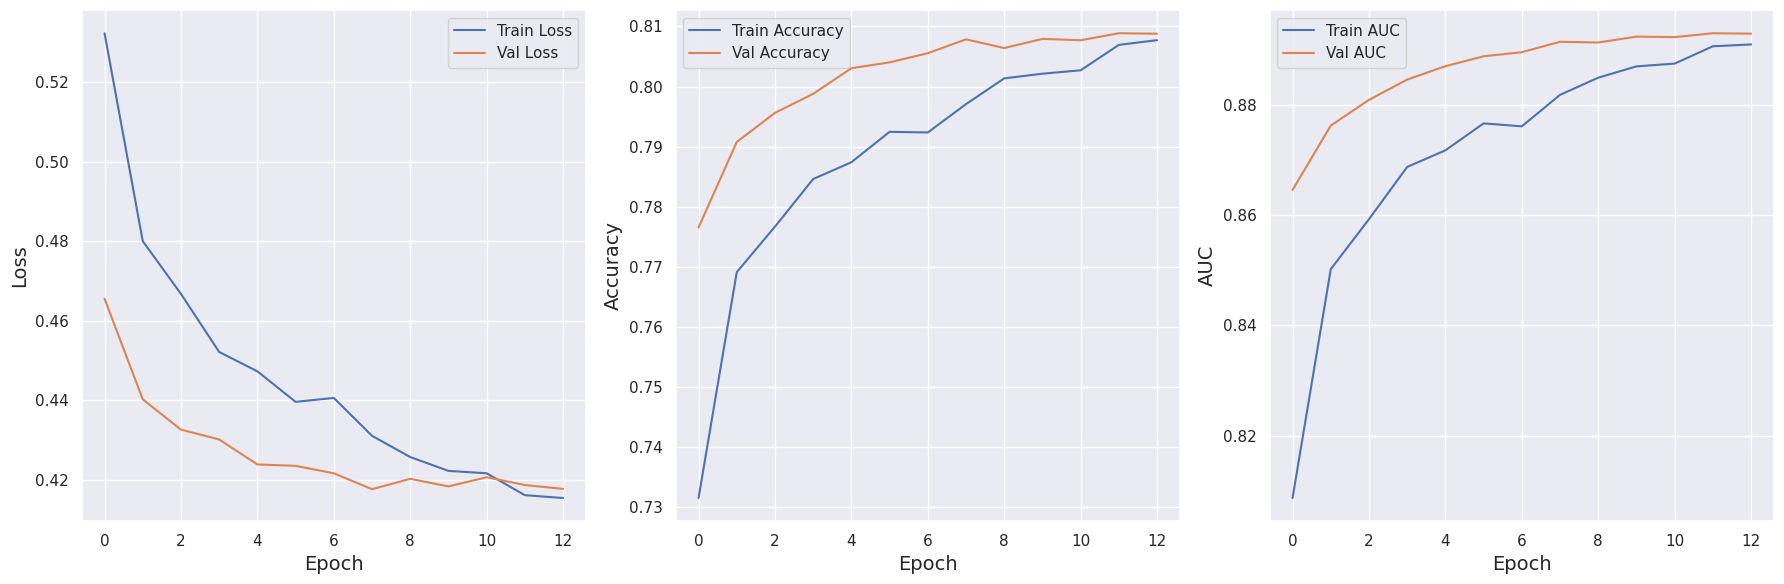

In [47]:
# Affichage des métriques au cours des époques
plot_history(history_LSTM_w2v)
plt.tight_layout()
plt.savefig('conv_history_LSTM_w2v.png')
plt.show()

In [48]:
def evaluate_model(model, train_data, test_data, y_train=None, y_test=None):
    """
    Évalue un modèle Keras sur les ensembles d'entraînement et de test, et mesure le temps d'inférence.

    Elle retourne les métriques de performance (accuracy et AUC) sur les deux ensembles, 
    ainsi que le temps d'inférence sur le jeu de test.

    Parameters
    ----------
    model : tf.keras.Model
        Modèle Keras compilé à évaluer.

    train_data : tf.data.Dataset ou array-like
        Données d'entraînement (dataset ou features).

    test_data : tf.data.Dataset ou array-like
        Données de test (dataset ou features).

    y_train : array-like, optional
        Labels d'entraînement (à fournir si `train_data` n'est pas un dataset).

    y_test : array-like, optional
        Labels de test (à fournir si `test_data` n'est pas un dataset).

    Returns
    -------
    train_accuracy : float
        Accuracy sur l’ensemble d'entraînement.

    train_AUC : float
        AUC sur l’ensemble d'entraînement.

    test_accuracy : float
        Accuracy sur l’ensemble de test.

    test_AUC : float
        AUC sur l’ensemble de test.

    test_pred_time : float
        Temps d’inférence (en secondes) sur le jeu de test.
    """
    # Vérifier si on utilise des datasets ou des paires X/y
    using_datasets = y_train is None and y_test is None
    
    # Évaluer le modèle sur les données d'entraînement
    if using_datasets:
        train_loss, train_accuracy, train_AUC = model.evaluate(train_data, verbose=0)
    else:
        train_loss, train_accuracy, train_AUC = model.evaluate(train_data, y_train, verbose=0)
    
    # Évaluer le modèle sur les données de test
    start_pred_time = time.time()
    if using_datasets:
        test_loss, test_accuracy, test_AUC = model.evaluate(test_data, verbose=0)
    else:
        test_loss, test_accuracy, test_AUC = model.evaluate(test_data, y_test, verbose=0)
    test_pred_time = time.time() - start_pred_time
    
    # Afficher les résultats
    print(f'Train Accuracy: {train_accuracy:.3f}')
    print(f'Train AUC: {train_AUC:.3f}')
    print(f'Test Accuracy: {test_accuracy:.3f}')
    print(f'Test AUC: {test_AUC:.3f}')
    
    return train_accuracy, train_AUC, test_accuracy, test_AUC, test_pred_time

In [49]:
# evalutation du modèle sur données de test et d'entraînement
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_LSTM_w2v,
    X_train_padded,
    X_test_padded,
    y_train,    
    y_test
)

Train Accuracy: 0.825
Train AUC: 0.908
Test Accuracy: 0.806
Test AUC: 0.889


Enregistrements avec MLflow :

In [50]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

In [51]:
times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

In [52]:
# Tracé courbe ROC
y_proba_test = model_LSTM_w2v.predict(X_test_padded, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle LSTM - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_LSTM_w2v.png')
plt.close()

In [53]:
artifacts = {
    'roc_curve': 'roc_curve_LSTM_w2v.png',
    'conv_history': 'conv_history_LSTM_w2v.png'
}

In [54]:
# récupère les paramètres des différentes couches de neurones
params = log_model_layers(model_LSTM_w2v)

In [55]:
example_text = "This is an example tweet for input serialization."

# Tokeniser l'exemple avec le tokenizer utilisé pour l'entraînement
example_sequence = tokenizer.texts_to_sequences([example_text])

# Appliquer le padding pour garantir que l'exemple a la bonne longueur
input_example = pad_sequences(example_sequence, maxlen=max_len)

In [56]:
# Appel de la fonction de log
log_experiment(
    model_LSTM_w2v,
    params,
    metrics,
    artifacts,
    input_example,
    times,
    "LSTM_w2v"
)

1/1 [==============================] - 0s 362ms/step
INFO:tensorflow:Assets written to: /tmp/tmp8nnv8eij/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8nnv8eij/model/data/model/assets


Modèle et résultats enregistrés dans MLflow sous le run ID: 8d906a69713a44d783089c0a4eb213d6


## LSTM avec embeddings Glove

In [57]:
# construction de la matrice d'embeddings
embedding_matrix = glove_embedding_matrix(tokenizer, max_words, 
                                          embedding_dim=100)

In [58]:
# construction du modèle LSTM
model_LSTM_glove = build_LSTM_model(embedding_matrix)
model_LSTM_glove.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1234753 (4.71 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [59]:
callbacks_LSTM_glove = create_callbacks(model_name="model_LSTM_glove",
                                        patience=5)

In [60]:
# Entrainement du modèle
start_fit_time = time.time() 
history_LSTM_glove = model_LSTM_glove.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_LSTM_glove,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/20
3199/3200 [============================>.] - ETA: 0s - loss: 0.5372 - accuracy: 0.7257 - auc: 0.8035
Epoch 1: val_loss improved from inf to 0.47832, saving model to ./checkpoints/model_LSTM_glove.keras
3200/3200 [==============================] - 79s 24ms/step - loss: 0.5373 - accuracy: 0.7257 - auc: 0.8035 - val_loss: 0.4783 - val_accuracy: 0.7662 - val_auc: 0.8501
Epoch 2/20
3198/3200 [============================>.] - ETA: 0s - loss: 0.4967 - accuracy: 0.7561 - auc: 0.8372
Epoch 2: val_loss improved from 0.47832 to 0.45542, saving model to ./checkpoints/model_LSTM_glove.keras
3200/3200 [==============================] - 77s 24ms/step - loss: 0.4967 - accuracy: 0.7561 - auc: 0.8372 - val_loss: 0.4554 - val_accuracy: 0.7822 - val_auc: 0.8673
Epoch 3/20
3198/3200 [============================>.] - ETA: 0s - loss: 0.4775 - accuracy: 0.7681 - auc: 0.8513
Epoch 3: val_loss improved from 0.45542 to 0.44723, saving model to ./checkpoints/model_LSTM_glove.keras
3200/3200 [========

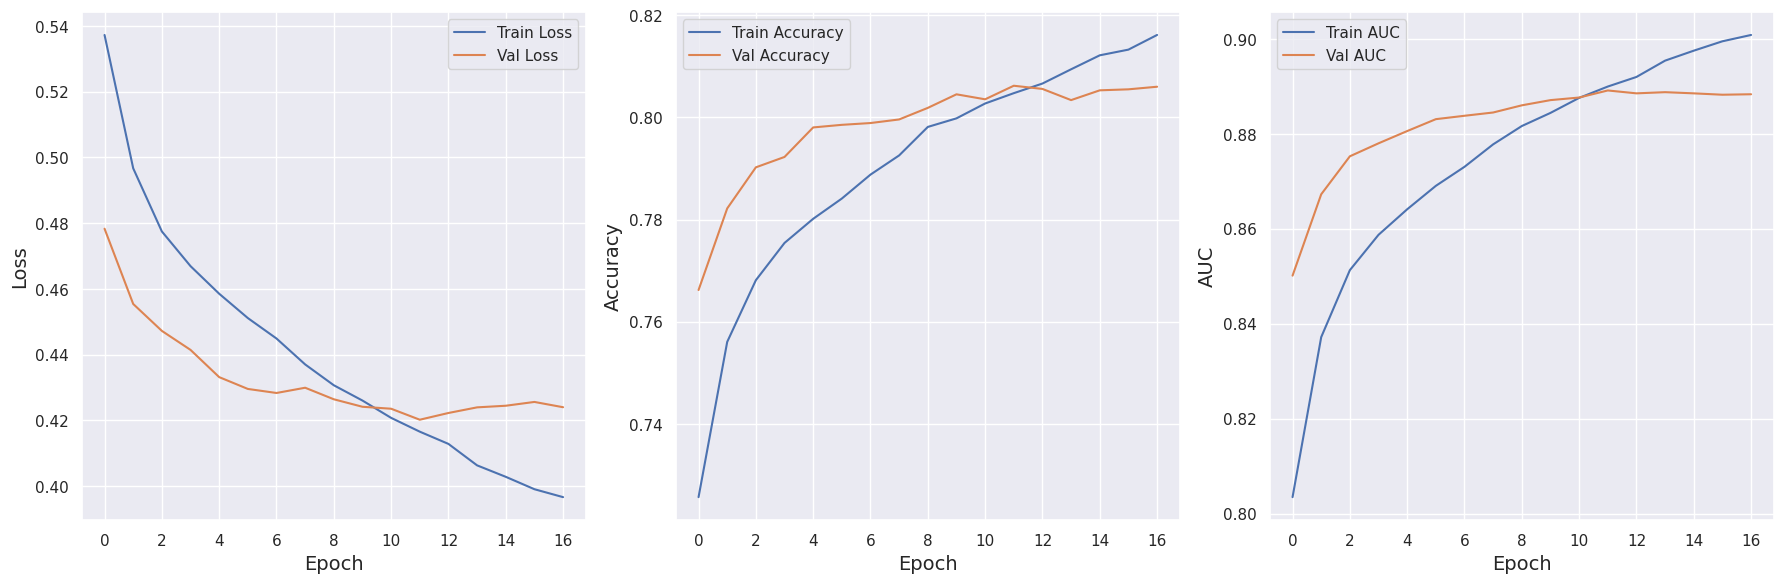

In [61]:
# Affichage des métriques au cours de époques
plot_history(history_LSTM_glove)
plt.tight_layout()
plt.savefig('conv_history_LSTM_glove.png')
plt.show()

In [62]:
# évaluation du modèle sur les données d'entrainement et de test
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_LSTM_glove,
    X_train_padded,
    X_test_padded,
    y_train,    
    y_test
)

Train Accuracy: 0.829
Train AUC: 0.914
Test Accuracy: 0.803
Test AUC: 0.888


Enregistrements avec MLflow :

In [63]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

# tracé de la courbe ROC
y_proba_test = model_LSTM_glove.predict(X_test_padded, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle LSTM - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_LSTM_glove.png')
plt.close()

artifacts = {
    'roc_curve': 'roc_curve_LSTM_glove.png',
    'conv_history': 'conv_history_LSTM_glove.png'
}

# récupère les paramètres des couches de neurones
params = log_model_layers(model_LSTM_glove)

In [64]:
# appel de la fonction de log
log_experiment(
    model_LSTM_glove,
    params,
    metrics,
    artifacts,
    input_example,
    times,
    "LSTM_glove"
)

1/1 [==============================] - 0s 397ms/step
INFO:tensorflow:Assets written to: /tmp/tmp6_m_tq24/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6_m_tq24/model/data/model/assets


Modèle et résultats enregistrés dans MLflow sous le run ID: ddea05a6cb2146d0b9be961a9d83a96f


## CNN

Construction d'un réseau de neurones convolutif, avec embeddings GloVe :

In [65]:
model_CNN = build_CNN_model(embedding_matrix)
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           38528     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1038657 (3.96 MB)
Trainable params: 38657 (151.00 KB)
Non-trainable params: 1000000 (3.81 MB)
____________

In [66]:
callbacks_CNN = create_callbacks(model_name="model_CNN",
                                        patience=5)

In [67]:
# Entrainement du CNN
start_fit_time = time.time() 
history_CNN = model_CNN.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_CNN,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/20
3198/3200 [============================>.] - ETA: 0s - loss: 0.5359 - accuracy: 0.7328 - auc: 0.8074
Epoch 1: val_loss improved from inf to 0.47355, saving model to ./checkpoints/model_CNN.keras
3200/3200 [==============================] - 17s 5ms/step - loss: 0.5359 - accuracy: 0.7329 - auc: 0.8074 - val_loss: 0.4736 - val_accuracy: 0.7775 - val_auc: 0.8574
Epoch 2/20
3196/3200 [============================>.] - ETA: 0s - loss: 0.4865 - accuracy: 0.7685 - auc: 0.8474
Epoch 2: val_loss improved from 0.47355 to 0.46213, saving model to ./checkpoints/model_CNN.keras
3200/3200 [==============================] - 16s 5ms/step - loss: 0.4865 - accuracy: 0.7685 - auc: 0.8474 - val_loss: 0.4621 - val_accuracy: 0.7834 - val_auc: 0.8644
Epoch 3/20
3199/3200 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.7784 - auc: 0.8575
Epoch 3: val_loss improved from 0.46213 to 0.45804, saving model to ./checkpoints/model_CNN.keras
3200/3200 [==============================]

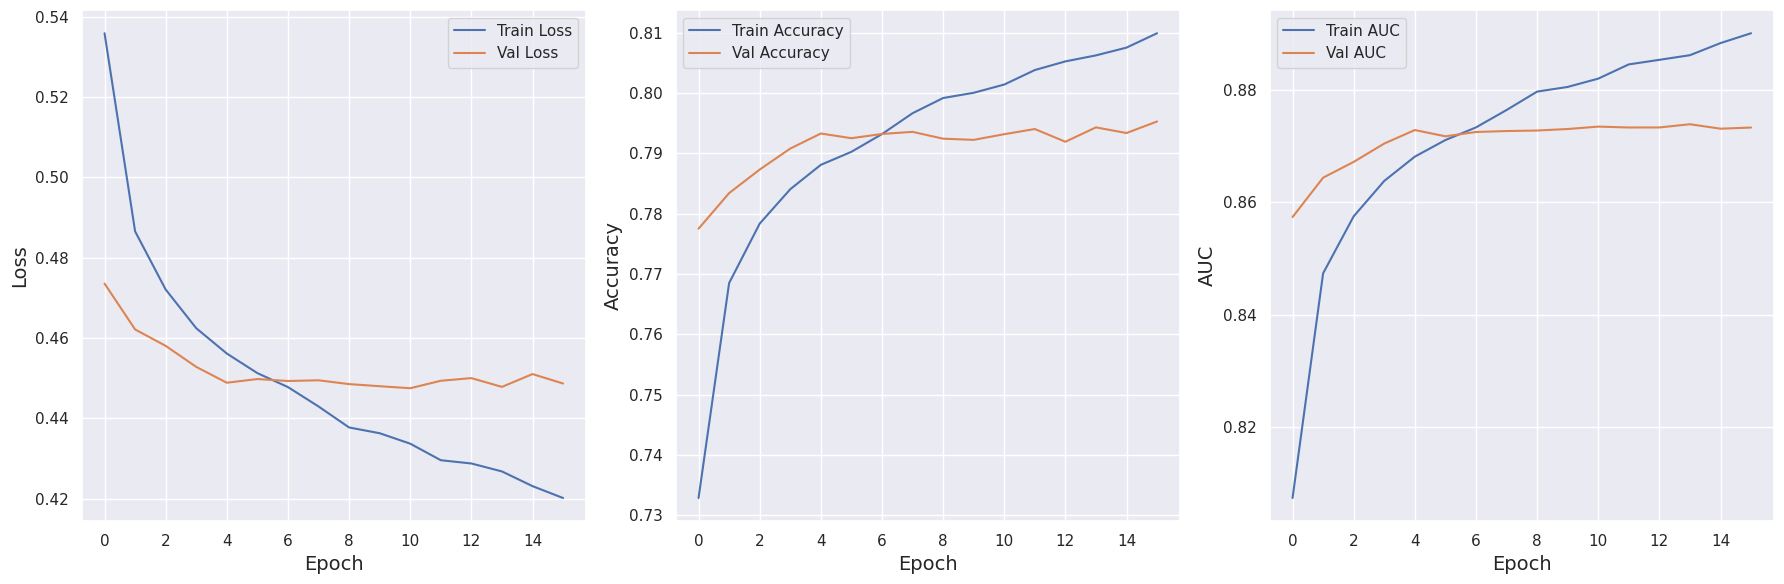

In [68]:
# Affichage des métriques au cours des époques
plot_history(history_CNN)
plt.tight_layout()
plt.savefig('conv_history_CNN.png')
plt.show()

In [69]:
# Évaluation du modèle
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_CNN,
    X_train_padded,
    X_test_padded,
    y_train,    
    y_test
)

Train Accuracy: 0.824
Train AUC: 0.904
Test Accuracy: 0.797
Test AUC: 0.877


Enregistrements avec MLflow :

In [70]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

In [71]:
y_proba_test = model_CNN.predict(X_test_padded, batch_size=32, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
sns.set()
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Test Data) - Modèle LSTM - AUC = {test_AUC:.3f}',
          fontweight='bold', fontsize=14)
plt.savefig('roc_curve_CNN.png')
plt.close()

artifacts = {
    'roc_curve': 'roc_curve_CNN.png',
    'conv_history': 'conv_history_CNN.png'
}

In [72]:
# récupère les paramètres des couches de neurones
params = log_model_layers(model_CNN)

In [73]:
# appel de la fonction de log
log_experiment(
    model_CNN,
    params,
    metrics,
    artifacts,
    input_example,
    times,
    "CNN"
)

1/1 [==============================] - 0s 154ms/step
INFO:tensorflow:Assets written to: /tmp/tmpxfr3nzek/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxfr3nzek/model/data/model/assets


Modèle et résultats enregistrés dans MLflow sous le run ID: 34aea745d7a34a5a8f6237dee9c68a98


# Modèle avancé BERT

Pour ce modèle avancé, nous avons utilisé DistilBERT, une version allégée de BERT conçue pour offrir des performances proches tout en étant plus rapide et moins coûteuse en ressources. Nous l'avons alors fine-tuné sur notre tâche de classification de sentiments.

## Prétraitement des données

In [74]:
def prepare_BERT_datasets(X_train, X_test, y_train, y_test, max_len, batch_size,
                                          val_split=0.2):
    """
    Prépare les datasets TensorFlow pour l'entraînement avec un modèle BERT,
    en utilisant directement X_train et X_test.

    :param X_train: Liste ou array de textes d'entraînement.
    :param X_test: Liste ou array de textes de test.
    :param y_train: Labels associés aux textes d'entraînement.
    :param y_test: Labels associés aux textes de test.
    :param max_len: Longueur maximale des séquences BERT.
    :param batch_size: Taille des batchs.
    :param val_split: Proportion des données d'entraînement réservée à la validation.
    :param tokenizer: (Optionnel) Tokenizer BERT préchargé. Si None, charge 'distilbert-base-uncased'.

    :return: Tuple `(train_dataset, val_dataset, test_dataset, tokenizer, train_size)`
    """
   
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    # Tokenisation des textes d'entraînement et de test
    train_inputs = tokenizer(list(X_train), max_length=max_len, padding=True, truncation=True, return_tensors="np")
    test_inputs = tokenizer(list(X_test), max_length=max_len, padding=True, truncation=True, return_tensors="np")

    train_input_ids = train_inputs['input_ids']
    train_attention_mask = train_inputs['attention_mask']
    test_input_ids = test_inputs['input_ids']
    test_attention_mask = test_inputs['attention_mask']

    # Taille d'entraînement pour le split val
    full_train_size = len(train_input_ids)
    val_size = int(full_train_size * val_split)
    train_size = full_train_size - val_size

    # Créer le dataset complet d'entraînement
    full_train_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': tf.constant(train_input_ids), 'attention_mask': tf.constant(train_attention_mask)},
        tf.constant(y_train)
    ))

    # Split en train/val
    train_dataset = full_train_dataset.take(train_size)
    val_dataset = full_train_dataset.skip(train_size)

    # Préparer le dataset test
    test_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': tf.constant(test_input_ids), 'attention_mask': tf.constant(test_attention_mask)},
        tf.constant(y_test)
    ))

    # Shuffle, batch, prefetch
    train_dataset = train_dataset.shuffle(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, tokenizer, train_size

In [75]:
max_len = 128
batch_size = 32
learning_rate = 2e-5
weight_decay_rate = 0.01
epochs = 6

In [76]:
train_dataset, val_dataset, test_dataset, bert_tokenizer, train_data_size = prepare_BERT_datasets(
    X_train, X_test, y_train, y_test, max_len=128, batch_size=32, val_split=0.2
)

## Construction du modèle

In [77]:
def build_BERT_model(learning_rate, weight_decay_rate, train_data_size, epochs):
    """
    Construit et compile un modèle DistilBERT pour la classification binaire, adapté au fine-tuning.

    Le modèle est basé sur `TFDistilBertForSequenceClassification` avec une seule
    unité de sortie (logits). 

    Parameters
    ----------
    learning_rate : float
        Taux d’apprentissage initial pour l’optimiseur.

    weight_decay_rate : float
        Taux de régularisation L2 (weight decay) appliqué pendant l'entraînement.

    train_data_size : int
        Taille du jeu d’entraînement, utilisé pour calculer le nombre de pas d’entraînement.

    epochs : int
        Nombre total d’époques prévues, utilisé pour calculer les steps totaux et le warmup.

    Returns
    -------
    model : tf.keras.Model
        Modèle DistilBERT compilé, prêt pour l’entraînement.
    """

    # Charger un modèle DistilBERT pré-entraîné pour classification binaire
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=1,        # Classification binaire (logits)
        dropout=0.5          # Dropout pour régularisation
    )

    # Calcul du nombre total de pas d'entraînement
    num_train_steps = (train_data_size // batch_size) * epochs
    # 10% des steps en phase de warm-up
    num_warmup_steps = int(0.1 * num_train_steps)

    # Création de l'optimiseur avec warm-up et weight decay
    optimizer, _ = create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        weight_decay_rate=weight_decay_rate
    )

    # Définir la fonction de perte (cross-entropie binaire avec logits)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Définir les métriques de suivi
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc')
    ]

    # Compiler le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [78]:
model_BERT = build_BERT_model(learning_rate, weight_decay_rate, train_data_size,
                             epochs)
model_BERT.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_20 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entraînement et évaluation du modèle

In [79]:
callbacks_BERT = create_callbacks(model_name="model_BERT",
                                        patience=3)

In [80]:
# Entrainement
start_fit_time = time.time() 
history_BERT = model_BERT.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_BERT,
    verbose=1
)
fit_time = time.time() - start_fit_time

Epoch 1/6
3200/3200 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.7265 - auc: 0.7819
Epoch 1: val_loss improved from inf to 0.42949, saving model to ./checkpoints/model_BERT.keras


/home/ngod/tensorflow/tf_venv/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


3200/3200 [==============================] - 537s 165ms/step - loss: 0.5079 - accuracy: 0.7265 - auc: 0.7819 - val_loss: 0.4295 - val_accuracy: 0.7866 - val_auc: 0.8205
Epoch 2/6
3200/3200 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.7942 - auc: 0.8354
Epoch 2: val_loss improved from 0.42949 to 0.39815, saving model to ./checkpoints/model_BERT.keras
3200/3200 [==============================] - 552s 172ms/step - loss: 0.4240 - accuracy: 0.7942 - auc: 0.8354 - val_loss: 0.3982 - val_accuracy: 0.8150 - val_auc: 0.8433
Epoch 3/6
3200/3200 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8107 - auc: 0.8480
Epoch 3: val_loss did not improve from 0.39815
3200/3200 [==============================] - 537s 168ms/step - loss: 0.3991 - accuracy: 0.8107 - auc: 0.8480 - val_loss: 0.4142 - val_accuracy: 0.8047 - val_auc: 0.8352
Epoch 4/6
3200/3200 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.8211 - auc: 0.8578
Epoch 4: val_l

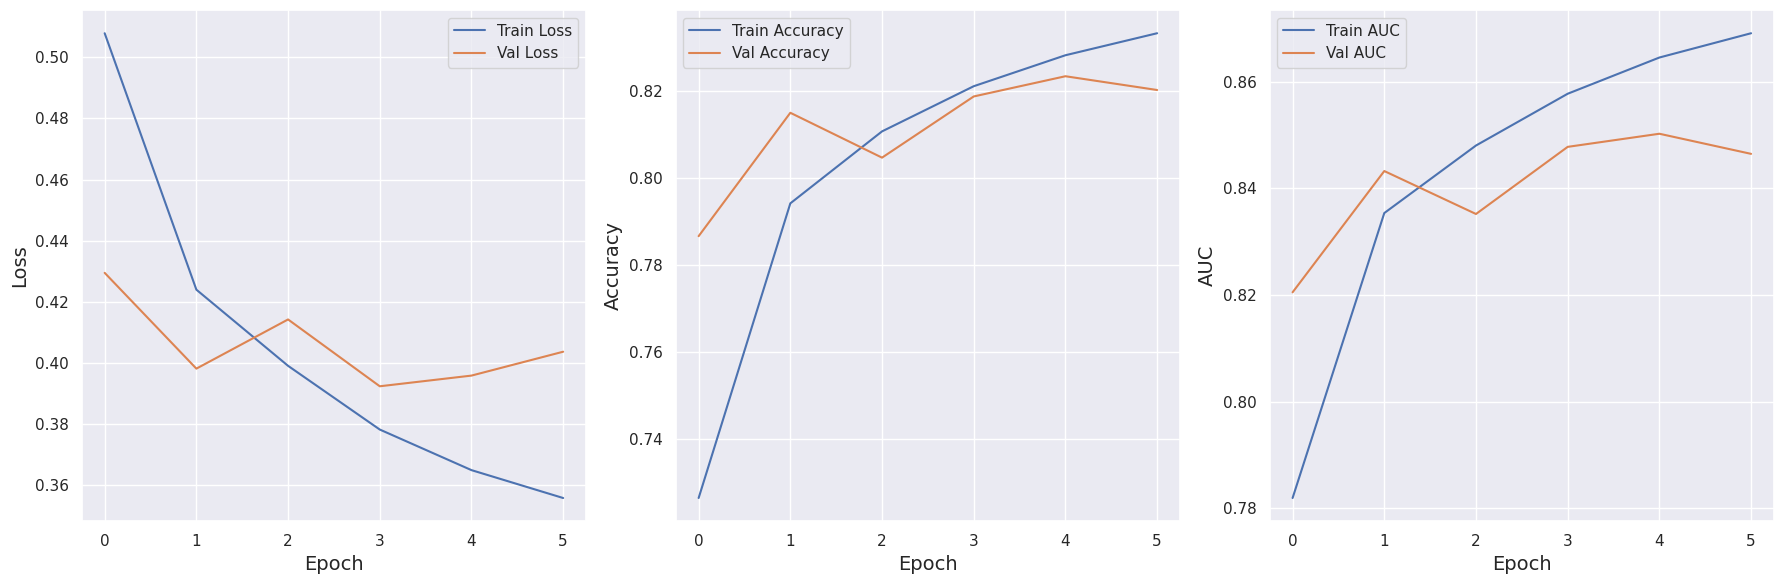

In [81]:
# Affichage des métriques au cours des époques
plot_history(history_BERT)
plt.tight_layout()
plt.savefig('conv_history_BERT.png')
plt.show()

In [82]:
# évalutation du modèle
train_accu, train_AUC, test_accu, test_AUC, test_pred_time = evaluate_model(
    model_BERT,
    train_dataset,
    test_dataset
)

Train Accuracy: 0.847
Train AUC: 0.875
Test Accuracy: 0.815
Test AUC: 0.842


## Enregistrements avec MLflow

In [83]:
metrics = {
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
    'Train AUC': train_AUC,
    'Test AUC': test_AUC,
}

times = {
    'fit_time': fit_time, 
    'test_predict_time': test_pred_time
}

artifacts = {
    'conv_history': 'conv_history_BERT.png'
}

In [84]:
params = log_model_layers(model_BERT)

In [85]:
# Exemple de texte
text = "This is a test sentence."

# Encode une seule phrase
example_encoded = bert_tokenizer(
    text,
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors="np"
)

input_example = {
    "input_ids": example_encoded["input_ids"],
    "attention_mask": example_encoded["attention_mask"]
}

In [86]:
# appel à la fonction de log
log_experiment(
    model_BERT,
    params,
    metrics,
    artifacts,
    input_example,
    times,
    "BERT"
)

1/1 [==============================] - 1s 825ms/step


INFO:tensorflow:Assets written to: /tmp/tmp71mkveic/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp71mkveic/model/data/model/assets


Modèle et résultats enregistrés dans MLflow sous le run ID: d779a297fcb043708af1e997b68021b2


# Enregistrement du modèle à déployer

Lorsqu’un modèle optimal est identifié parmi les runs sauvegardés avec MLflow, il est enregistré en vue de son déploiement sous forme d’API.

In [87]:
# chargement via mlflow du modèle à déployer 
deployed_model = mlflow.keras.load_model('runs:/826af6b6b6664f2f9c695772c629d71e/model')

# enregistrement du modèle au format .h5
deployed_model.save('model_LSTM.h5')